In [6]:
# Imports

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from copy import deepcopy

import os
import ray
from ray.rllib.algorithms.ppo import PPOConfig
from ray import tune

from src.parsers import PecanParser
from src.resources import BinaryResource, Generator, Load, Storage, Vehicle, Aggregator
from src.algorithms.rl import EnergyCommunityMultiHouseholdsEnv_v1
from src.utils.plotting import households_plots

import opencensus  # noqa: F401

import prometheus_client  # noqa: F401

import aiohttp  # noqa: F401
import aiohttp.web  # noqa: F401
import aiohttp_cors  # noqa: F401
from aiohttp import hdrs  # noqa: F401
from aiohttp.typedefs import PathLike  # noqa: F401
from aiohttp.web import RouteDef  # noqa: F401
import pydantic  # noqa: F401
import grpc  # noqa: F401

In [8]:
pecan_parser = PecanParser('data/pecan_street/15minute_data_newyork.csv',
                           'data/pecan_street/metadata_reduced.csv',
                           'data/pecan_street/prices_new_york.csv')
pecan_parser.parse()


In [9]:
resources = pecan_parser.get_parsed_resources()
print(resources)

Length of household 27 timeseries 17663
Length of household 142 timeseries 17664
Length of household 387 timeseries 17664
Length of household 558 timeseries 17664
Length of household 914 timeseries 17664
Length of household 950 timeseries 17664
Length of household 1222 timeseries 17664
Length of household 1240 timeseries 17664
Length of household 1417 timeseries 17664
Length of household 2096 timeseries 17664
Length of household 2318 timeseries 17664
Length of household 2358 timeseries 17664
Length of household 3000 timeseries 17664
Length of household 3488 timeseries 17664
Length of household 3517 timeseries 17664
Length of household 3700 timeseries 17664
Length of household 3996 timeseries 17664
Length of household 4283 timeseries 17664
Length of household 4550 timeseries 17664
Length of household 5058 timeseries 17664
Length of household 5587 timeseries 17664
Length of household 5679 timeseries 17664
Length of household 5982 timeseries 17664
Length of household 5997 timeseries 17664

In [10]:
resources = pecan_parser.get_parsed_resources(start_time='2019-05-09', end_time='2019-05-11')
prediction_window = 24 * 4
max_timesteps = resources[0]['load'].value.shape[0] - prediction_window

Length of household 27 timeseries 192
Length of household 142 timeseries 192
Length of household 387 timeseries 192
Length of household 558 timeseries 192
Length of household 914 timeseries 192
Length of household 950 timeseries 192
Length of household 1222 timeseries 192
Length of household 1240 timeseries 192
Length of household 1417 timeseries 192
Length of household 2096 timeseries 192
Length of household 2318 timeseries 192
Length of household 2358 timeseries 192
Length of household 3000 timeseries 192
Length of household 3488 timeseries 192
Length of household 3517 timeseries 192
Length of household 3700 timeseries 192
Length of household 3996 timeseries 192
Length of household 4283 timeseries 192
Length of household 4550 timeseries 192
Length of household 5058 timeseries 192
Length of household 5587 timeseries 192
Length of household 5679 timeseries 192
Length of household 5982 timeseries 192
Length of household 5997 timeseries 192
Length of household 9053 timeseries 192


In [11]:
# Create the environment and check if everything is ok
import_penalty = 500
export_penalty = 500
storage_action_reward = 0
storage_action_penalty = 500
balance_penalty = 0
# TODO: Take costs from the excel file
temp_env = EnergyCommunityMultiHouseholdsEnv_v1(households_resources=resources, import_penalty=import_penalty,
                                                export_penalty=export_penalty,
                                                storage_action_penalty=storage_action_penalty,
                                                storage_action_reward=storage_action_reward,
                                                balance_penalty=balance_penalty,
                                                max_timesteps=max_timesteps,
                                                saving_dir='results/test')
temp_env.reset()
terminations = truncations = {a: False for a in temp_env.households}
terminations['__all__'] = False
truncations['__all__'] = False
while not terminations['__all__'] and not truncations['__all__']:
    actions = temp_env.action_space.sample()
    observations, rewards, terminations, truncations, infos = temp_env.step(actions)
    # print('Observation: {}'.format(observations))
    # print('Observation keys: {}'.format(observations.keys()))
    print('Reward: {}'.format(rewards))
    # print('Infos: {}\n'.format(infos))
print('Terminated: {}'.format(terminations['__all__']))

Household 0 --- Produced energy: -0.003
Household 0 --- Current available energy: -0.003
Household 0 --- Discharged 0.0 to the total value of 0.0
Household 1 --- Produced energy: -0.001
Household 1 --- Current available energy: -0.001
Household 1 --- Discharged 0.0 to the total value of 0.0
Household 2 --- Produced energy: -0.002
Household 2 --- Current available energy: -0.002
Household 2 --- Charged 0.0841191190260428 to the total value of 0.0841191190260428
Household 3 --- Discharged 0.0 to the total value of 0.0
Household 4 --- Produced energy: 0.0
Household 4 --- Current available energy: 0.0
Household 4 --- Did not perform any storage action
Household 5 --- Produced energy: -0.012
Household 5 --- Current available energy: -0.012
Household 5 --- Charged 0.11999070644378662 to the total value of 0.11999070644378662
Household 6 --- Produced energy: -0.004
Household 6 --- Current available energy: -0.004
Household 6 --- Discharged 0.0 to the total value of 0.0
Household 7 --- Produce

In [7]:
# Verify the data by plotting it
pecan_parser.plot_tables()

KeyboardInterrupt: 

In [12]:
# Aux function to assign policies

def assign_policies(env):
    policies = {}
    for household_id in env.households:
        policies[str(household_id)] = (None,
                                       env.observation_space[household_id],
                                       env.action_space[household_id],
                                       {})
    return policies


policies = assign_policies(env=temp_env)

In [14]:
from ray.tune import register_env

# Create an RLlib Algorithm instance from a PPOConfig to learn how to
# act in the above environment.

ray.shutdown()
context = ray.init(include_dashboard=True)
print(context.dashboard_url)
# Get next free available directory name
i = 1
while os.path.exists('results/run_results_{:s}'.format(str(i).zfill(2))):
    i += 1
run_env = EnergyCommunityMultiHouseholdsEnv_v1(households_resources=resources,
                                               import_penalty=import_penalty,
                                               export_penalty=export_penalty,
                                               storage_action_penalty=storage_action_penalty,
                                               storage_action_reward=storage_action_reward,
                                               balance_penalty=balance_penalty,
                                               max_timesteps=max_timesteps,
                                               saving_dir='results/run_results_{:s}'.format(str(i).zfill(2)),
                                               printing=False)
register_env("EC_Multi", lambda config: run_env)

config = (
    PPOConfig()
    .environment(env="EC_Multi")
    .training(
        train_batch_size=240,
        lr=2e-4,
        gamma=0.99)
    # entropy_coeff=0.05,
    # kl_coeff=0.0)
    .resources(num_gpus=1)
    .framework('torch')  # 'tf2', eager_tracing=False)
    .env_runners(num_env_runners=10, rollout_fragment_length=24)
    .reporting()
    .multi_agent(policies=policies,
                 policy_mapping_fn=lambda agent_id, episode, worker, **kwargs: str(agent_id))
)
# Use the config's `build()` method to construct a PPO object.
algo = config.build()

# Train for n iterations and report results (mean episode rewards).
# Since we have to guess 10 times and the optimal reward is 0.0
# (exact match between observation and action value),
# we can expect to reach an optimal episode reward of 0.0.
checkpoint = None

for training_iteration in range(1000):
    results = algo.train()
    print(f"Iter: {training_iteration}; avg. reward={results['episode_reward_mean']}")
    if results['episode_reward_mean'] > -50.0:
        break

    # Save the checkpoint to disk.
    if i % 10 == 0:
        checkpoint_dir = 'results/run_results_{:s}'.format(str(i).zfill(2)) + '/checkpoints' + '/checkpoint_{:s}'.format(str(training_iteration).zfill(2))
        checkpoint = algo.save(checkpoint_dir)
    print("checkpoints saved at ", checkpoint)

2024-06-19 02:48:07,712	INFO worker.py:1740 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


127.0.0.1:8265


C:\Users\micha\miniconda3\envs\pyecom\lib\site-packages\ray\rllib\algorithms\algorithm.py:525: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
C:\Users\micha\miniconda3\envs\pyecom\lib\site-packages\ray\tune\logger\unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
C:\Users\micha\miniconda3\envs\pyecom\lib\site-packages\ray\tune\logger\unified.py:53: RayDeprecationWarning: This API is deprecated and may be 

(RolloutWorker pid=28232) Household 0 --- Produced energy: -0.003
(RolloutWorker pid=28232) Household 0 --- Current available energy: -0.003
(RolloutWorker pid=28232) Household 0 --- Did not perform any storage action
(RolloutWorker pid=28232) Household 1 --- Produced energy: -0.001
(RolloutWorker pid=28232) Household 1 --- Current available energy: -0.001
(RolloutWorker pid=28232) Household 1 --- Did not perform any storage action
(RolloutWorker pid=28232) Household 2 --- Produced energy: -0.002
(RolloutWorker pid=28232) Household 2 --- Current available energy: -0.002
(RolloutWorker pid=28232) Household 2 --- Did not perform any storage action
(RolloutWorker pid=28232) Household 3 --- Charged 0.0 to the total value of 0.0
(RolloutWorker pid=28232) Household 4 --- Produced energy: 0.0
(RolloutWorker pid=28232) Household 4 --- Current available energy: 0.0
(RolloutWorker pid=28232) Household 4 --- Charged 0.3185719030874747 to the total value of 0.3185719030874747
(RolloutWorker pid=28

(RolloutWorker pid=40996) 2024-06-19 02:48:26,400	WARNING deprecation.py:50 -- DeprecationWarning: `num_envs_per_worker` has been deprecated. Use `AlgorithmConfig.num_envs_per_env_runner` instead. This will raise an error in the future!


Iter: 0; avg. reward=nan
checkpoints saved at  TrainingResult(checkpoint=Checkpoint(filesystem=local, path=results/run_results_00/checkpoints/checkpoint_00), metrics={'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'17': {'learner_stats': {'allreduce_latency': 0.0, 'grad_gnorm': 1.4216721991697947, 'cur_kl_coeff': 0.19999999999999993, 'cur_lr': 0.00020000000000000006, 'total_loss': 9.260853497187297, 'policy_loss': -0.1623260876784722, 'vf_loss': 9.41629581451416, 'vf_explained_var': 9.934107462565104e-10, 'kl': 0.03441766802933534, 'entropy': 5.373207998275757, 'entropy_coeff': 0.0}, 'model': {}, 'custom_metrics': {}, 'num_agent_steps_trained': 120.0, 'num_grad_updates_lifetime': 30.5, 'diff_num_grad_updates_vs_sampler_policy': 29.5}, '9': {'learner_stats': {'allreduce_latency': 0.0, 'grad_gnorm': 1.5009735186894735, 'cur_kl_coeff': 0.19999999999999993, 'cur_lr': 0.00020000000000000006, 'total_loss': 8.931071885426839, 'policy_loss': -0.15755704045295715, 'vf_loss': 9.

KeyboardInterrupt: 

In [3]:
import sys

print(sys.executable)


C:\Users\micha\miniconda3\envs\pyecom\python.exe


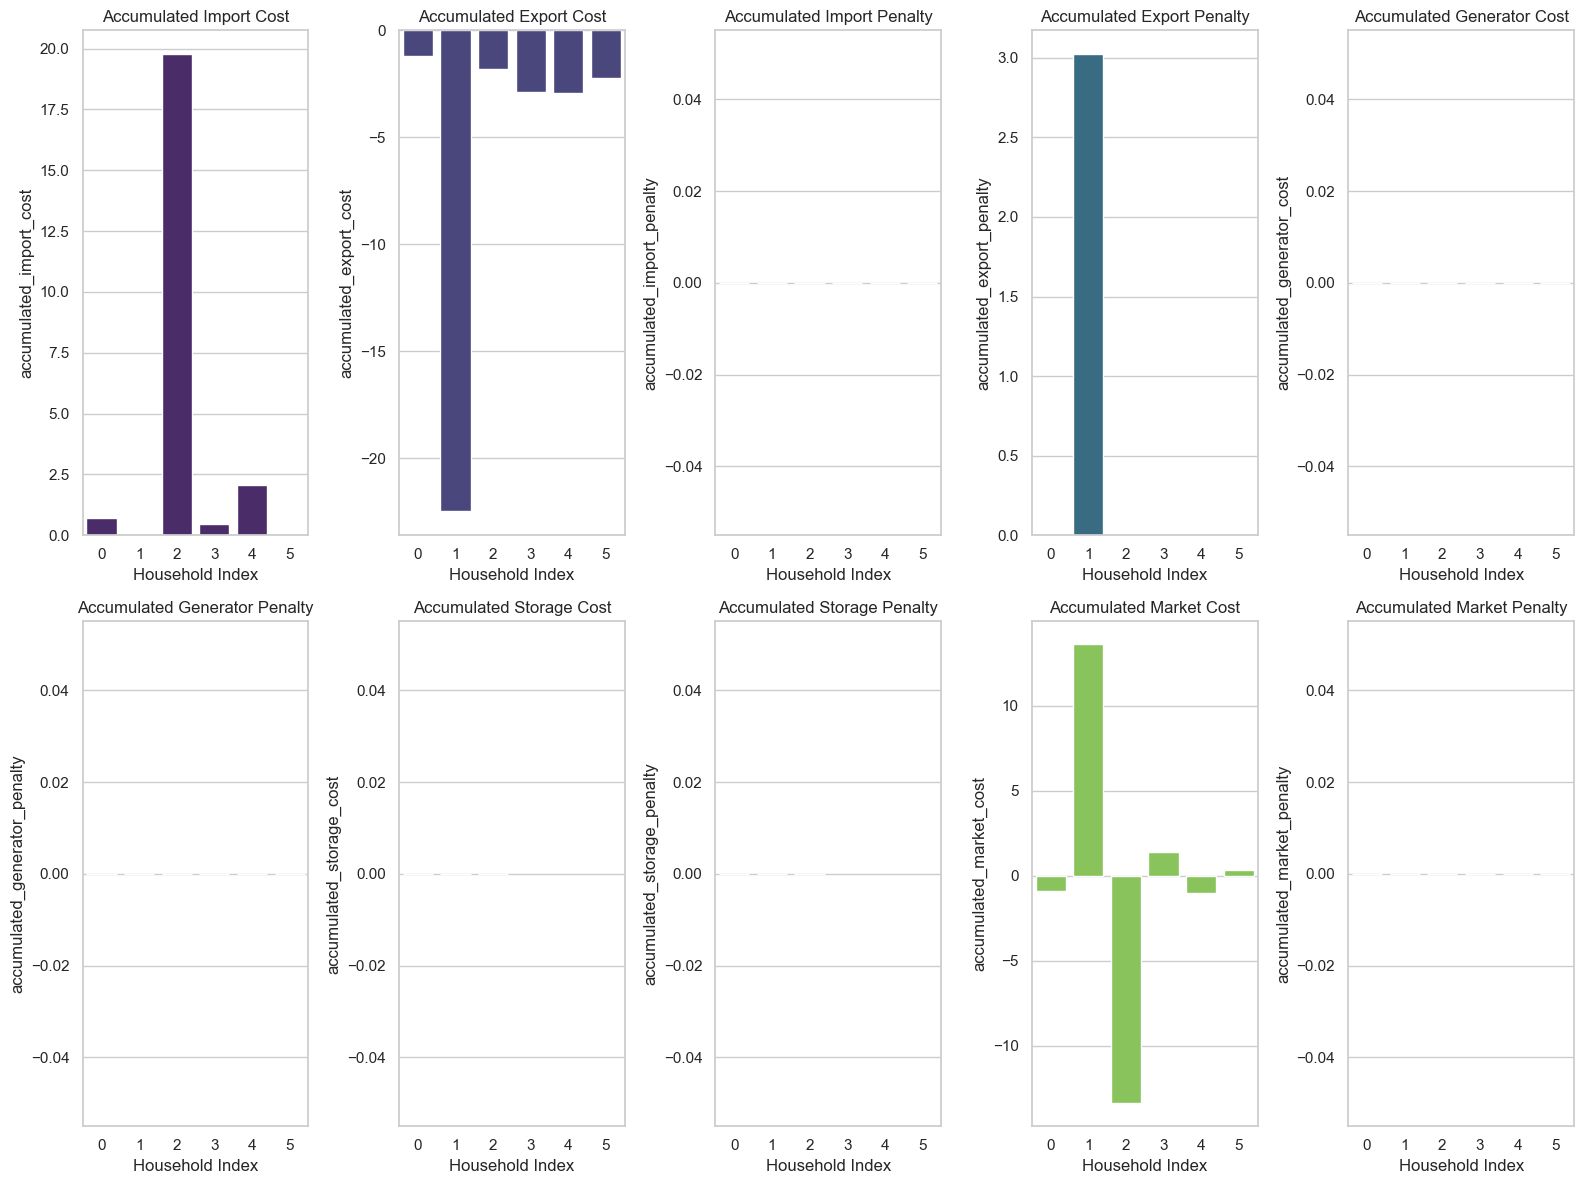

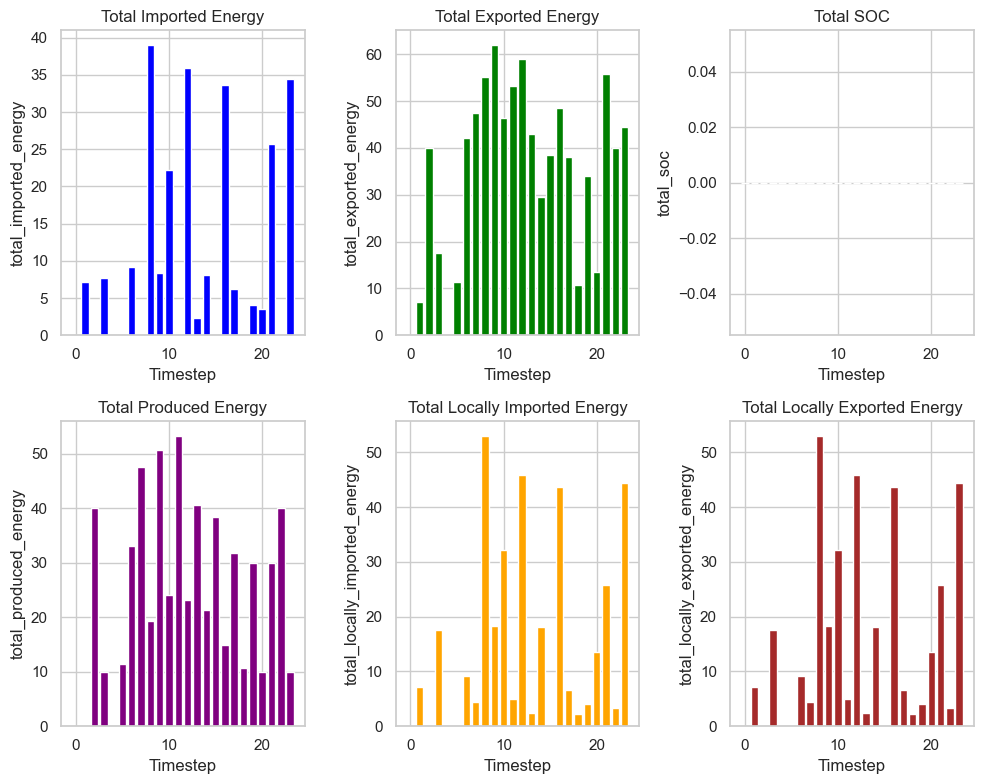

In [3]:
# Try reading and plotting some saved results

pd_per_timestep_logs = pd.read_csv('results/run_results_10/run_results_2024-06-08_22-00-54/aggregated_results.csv')
pd_per_household_logs = pd.read_csv(
    'results/run_results_10/run_results_2024-06-08_22-00-54/accumulated_household_logs.csv')
households_plots.plot_per_household_logs(pd_per_household_logs)
households_plots.plot_per_timestep_logs(pd_per_timestep_logs)


In [11]:
print(results['info'])

{'learner': {'2': {'learner_stats': {'allreduce_latency': 0.0, 'grad_gnorm': 1.1602941537896792, 'cur_kl_coeff': 0.3000000000000001, 'cur_lr': 0.00020000000000000006, 'total_loss': 9.272882334391277, 'policy_loss': -0.028678646903911916, 'vf_loss': 9.29598782857259, 'vf_explained_var': 0.0, 'kl': 0.018577102248673327, 'entropy': 3.1413570364316303, 'entropy_coeff': 0.0}, 'model': {}, 'custom_metrics': {}, 'num_agent_steps_trained': 120.0, 'num_grad_updates_lifetime': 150.5, 'diff_num_grad_updates_vs_sampler_policy': 29.5}, '5': {'learner_stats': {'allreduce_latency': 0.0, 'grad_gnorm': 4.216883444786072, 'cur_kl_coeff': 0.45000000000000007, 'cur_lr': 0.00020000000000000006, 'total_loss': 0.5476969455679258, 'policy_loss': -0.06533034999544422, 'vf_loss': 0.595736688375473, 'vf_explained_var': 0.23356647888819376, 'kl': 0.03842356836733719, 'entropy': 3.8799327969551087, 'entropy_coeff': 0.0}, 'model': {}, 'custom_metrics': {}, 'num_agent_steps_trained': 120.0, 'num_grad_updates_lifetim

In [9]:
algo.get_state()

{'iteration': 20,
 'timesteps_total': None,
 'time_total': 71.17653465270996,
 'episodes_total': 190,
 'last_result': {'custom_metrics': {},
  'episode_media': {},
  'info': {'learner': {'2': {'learner_stats': {'allreduce_latency': 0.0,
      'grad_gnorm': 1.6072334080934525,
      'cur_kl_coeff': 0.7593750000000001,
      'cur_lr': 0.00020000000000000006,
      'total_loss': 6.859228324890137,
      'policy_loss': -0.03356546958287557,
      'vf_loss': 6.883545589447022,
      'vf_explained_var': -2.22325325012207e-06,
      'kl': 0.012178834398218897,
      'entropy': 2.0924310167630513,
      'entropy_coeff': 0.0},
     'model': {},
     'custom_metrics': {},
     'num_agent_steps_trained': 120.0,
     'num_grad_updates_lifetime': 1170.5,
     'diff_num_grad_updates_vs_sampler_policy': 29.5},
    '4': {'learner_stats': {'allreduce_latency': 0.0,
      'grad_gnorm': 1.7638625343640646,
      'cur_kl_coeff': 1.0125000000000004,
      'cur_lr': 0.00020000000000000006,
      'total_loss

In [12]:
print(run_env.final_logs)

{}


In [13]:
print(results)

{'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'3': {'learner_stats': {'allreduce_latency': 0.0, 'grad_gnorm': 1.6330956747134526, 'cur_kl_coeff': 0.42714843750000014, 'cur_lr': 0.00020000000000000006, 'total_loss': 0.0726798781446026, 'policy_loss': -0.005388709735901405, 'vf_loss': 0.07574741064260403, 'vf_explained_var': 0.22685865064462027, 'kl': 0.005434127669286681, 'entropy': 2.413917370637258, 'entropy_coeff': 0.0}, 'model': {}, 'custom_metrics': {}, 'num_agent_steps_trained': 120.0, 'num_grad_updates_lifetime': 5430.5, 'diff_num_grad_updates_vs_sampler_policy': 29.5}, '2': {'learner_stats': {'allreduce_latency': 0.0, 'grad_gnorm': 2.280141690870126, 'cur_kl_coeff': 0.17105230093002324, 'cur_lr': 0.00020000000000000006, 'total_loss': 6.2662955602010095, 'policy_loss': -0.010461809191648777, 'vf_loss': 6.272536436716716, 'vf_explained_var': 0.035218591491381325, 'kl': 0.024675651859433857, 'entropy': 1.6336575706799825, 'entropy_coeff': 0.0}, 'model': {}, 'cust